This notebook shows how to use hybrid kernel, which is tensorproduct of marginalized graph kernel (MGK) and radial basis function (RBF) kernel.

For MGK, input is molecular graph.

For RBF kernel, input is RDKit features.

The hyperparameters are saved in directory freesolv_hyperparameters [1].

References:

[1] Xiang Y, Tang Y H, Lin G, et al. A comparative study of marginalized graph kernel and message-passing neural network[J]. Journal of Chemical Information and Modeling, 2021, 61(11): 5414-5424.

In [1]:
import pandas as pd
df = pd.read_csv('../datasets/freesolv.csv')
from mgktools.data.data import Dataset
dataset = Dataset.from_df(
    df,
    pure_columns = ['smiles'],
    target_columns = ['freesolv'],
    features_generator = ['rdkit_2d_normalized'],
    n_jobs = 6
)
# Save the dataset as dataset.pkl.
import os
if not os.path.exists('freesolv'):
    os.mkdir('freesolv')
dataset.save(path='freesolv', filename='dataset.pkl', overwrite=True)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 642 out of 642 | elapsed:    7.3s finished


In [2]:
from mgktools.kernels.utils import get_kernel_config
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'graph',
    # arguments for marginalized graph kernel
    mgk_hyperparameters_files = ['freesolv_hyperparameters/hyperparameters_0.json'],
    # arguments for RBF kernel
    # features_hyperparameters_file = 'freesolv_hyperparameters/features_hyperparameters.json'
)
kernel = kernel_config.kernel

In [3]:
dataset.graph_kernel_type = 'graph'
kernel_dict = kernel_config.get_kernel_dict(dataset.X_graph, dataset.X_repr.ravel())
import os, pickle
kernel_pkl = os.path.join('freesolv', 'kernel.pkl')
pickle.dump(kernel_dict, open(kernel_pkl, 'wb'), protocol=4)

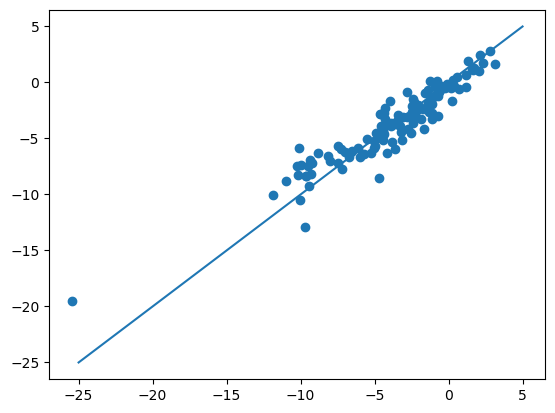

In [4]:
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'pre-computed',
    # arguments for pre-computed kernel
    kernel_pkl = 'freesolv/kernel.pkl',
    features_hyperparameters_file = 'freesolv_hyperparameters/features_hyperparameters.json'
)
kernel = kernel_config.kernel

dataset.graph_kernel_type = 'pre-computed'
from mgktools.data import dataset_split
train, test = dataset_split(dataset, 
                            split_type='random',
                            sizes=[0.8, 0.2])
from mgktools.models.regression.GPRgraphdot.gpr import GPR
gpr = GPR(kernel=kernel,
          optimizer=None,
          alpha=0.01,
          normalize_y=True)
gpr.fit(train.X, train.y)
y_pred = gpr.predict(test.X)
import matplotlib.pyplot as plt
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])